<Axes: xlabel='date'>

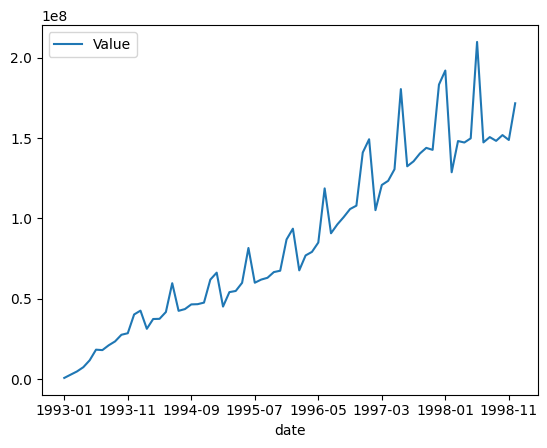

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.linear_model import LinearRegression
import warnings


warnings.filterwarnings("ignore")

df = pd.read_csv('df.csv',parse_dates=True,index_col='date')
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['amount'])
df.columns=['Value']



df.plot()

<h1> Part 1 : Differencing

In [49]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    print(type(time_series))
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used', "Critical Values"]

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    return result[1]
adf_check(np.log(df.Value).diff().diff(12).dropna())

<class 'pandas.core.series.Series'>
Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.225226609713747
p-value : 7.80717692014732e-06
Number of Lags Used : 3
Number of Observations Used : 55
Critical Values : {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}


7.80717692014732e-06

Order: [1]
<class 'pandas.core.series.Series'>
Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.2814795547740245
p-value : 0.6376022750386238
Number of Lags Used : 12
Number of Observations Used : 58
Critical Values : {'1%': -3.548493559596539, '5%': -2.912836594776334, '10%': -2.594129155766944}


[date
 1993-02    1.356772
 1993-03    0.550818
 1993-04    0.444560
 1993-05    0.459390
 1993-06    0.448519
              ...   
 1998-08    0.022165
 1998-09   -0.015667
 1998-10    0.023932
 1998-11   -0.020268
 1998-12    0.142846
 Name: Value, Length: 71, dtype: float64,
 False]

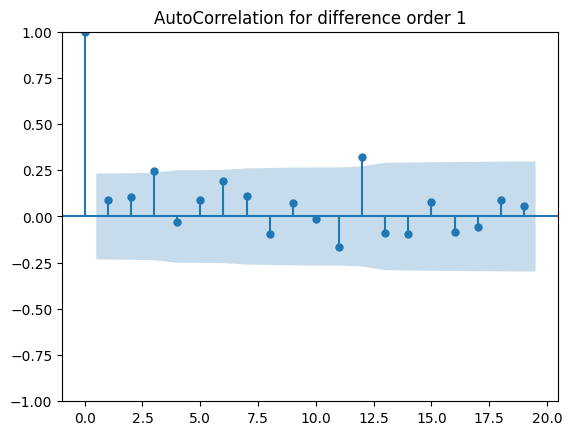

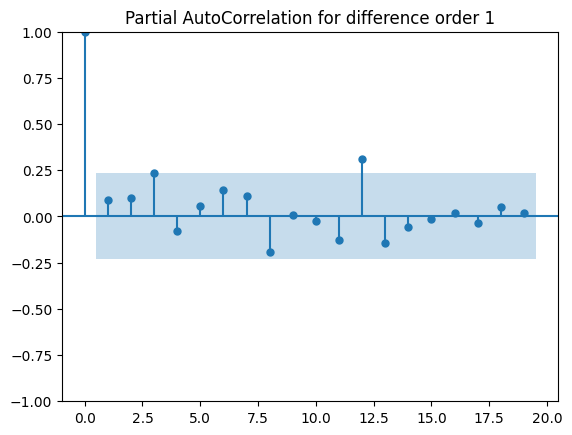

In [50]:
def I(df,order):
    a=df.copy()
    print("Order:",order)
    for i in order:
        if(i==0) : break
        a=a.diff(i)
        
    a = pd.DataFrame(a,columns=['Value'])
    a=a.Value.dropna()
    
    
    p=adf_check(a)
    plot_acf(a,title=f'AutoCorrelation for difference order {len(order)}')
    plot_pacf(a,title=f'Partial AutoCorrelation for difference order {len(order)}')
    return [a,p<.05]
I(np.log(df.Value),[1])

#if(I[1]==1) the data is stationary

<br></br>
<h1>Part 2: AR Auto-Regressive

In [51]:
def AR(p,df):
    df_temp=df.copy()
    
    for i in range(1,p+1):
        df_temp[f'Value_Lag {i}']=df_temp["Differenced_Value"].shift(i)
    
    df_temp=df_temp.dropna()
    train_size= (int)(.8*df_temp.shape[0])
    train=df_temp[0:train_size]
    x=train.iloc[:,2:]
    
    y=train.iloc[:,1]
    
    test=df_temp[train_size::]
    y_t=test.iloc[:,0]
    x_t=test.iloc[:,2:]
    lr=LinearRegression()
    lr.fit(x,y)
    theta=lr.coef_
    intercept=lr.intercept_
    train['Predicted_Values'] = x.dot(lr.coef_.T) + lr.intercept_
    test['Predicted_Values']=x_t.dot(theta)+intercept
  
    RMSE=np.sqrt(mean_squared_error(test['Differenced_Value'],test['Predicted_Values']))
    print(type(train["Predicted_Values"]))
    Ar_Predictions=pd.concat([train['Predicted_Values'],test['Predicted_Values']])
    residuals=pd.DataFrame(df_temp['Differenced_Value']-Ar_Predictions,columns=['Residuals'])
    print(RMSE)
    return [RMSE,residuals,theta,intercept]


<h1>Part 3 - MA : Moving Average

In [52]:

def MA(q,res):#residuals
    res_temp=res.copy()
    
    for i in range(1,q+1):
        res_temp[f'Residual_Lag {i}']=res_temp["Residue"].shift(i)
    
    res_temp=res_temp.dropna()
    train_size= (int)(.8*res_temp.shape[0])
    train=res_temp[0:train_size]
    x=train.iloc[:,3:]
    y=train.iloc[:,2]
   

    test=res_temp[train_size::]
    y_t=test.iloc[:,2]
    x_t=test.iloc[:,3:]
    lr=LinearRegression()
    lr.fit(x,y)
    theta=lr.coef_
    intercept=lr.intercept_
    train['Predicted_Residue'] = x.dot(lr.coef_.T) + lr.intercept_
    test['Predicted_Residue']=x_t.dot(theta)+intercept
    res_temp['Predicted_Residue']=pd.concat([train['Predicted_Residue'],test["Predicted_Residue"]])
    RMSE=np.sqrt(mean_squared_error(test['Residue'],test['Predicted_Residue']))
    
    
    return [theta,intercept,RMSE]


In [53]:

def GetBackData(predict_data,order):
    temp=predict_data.copy()
    k=0
    for i in order:
        if(k):
            temp[f'lag{k}']=temp[f'lag{k-1}'].diff(i)
        else : temp[f'lag{k}']=temp['Value'].diff(i)
        k+=1
    k-=1
    while(k):
        predict_data['Predictions']+=temp[f'lag{k-1}'].shift(order[k])
        predict_data['Differenced_Value']+=temp[f'lag{k-1}'].shift(order[k])
        k-=1
    predict_data['Predictions']+=temp['Value'].shift(order[k])
    predict_data['Differenced_Value']+=temp['Value'].shift(order[k])
    return predict_data
    

Order: [1, 12]
<class 'pandas.core.series.Series'>
Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.225226609713747
p-value : 7.80717692014732e-06
Number of Lags Used : 3
Number of Observations Used : 55
Critical Values : {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}
             Value  Differenced_Value
date                                 
1994-02  17.258546          -1.665408
1994-03  17.436748          -0.372616
1994-04  17.439628          -0.441680
1994-05  17.546830          -0.352188
1994-06  17.904447          -0.090902
1994-07  17.564415          -0.325125
1994-08  17.589790          -0.128964
1994-09  17.654529          -0.043756
1994-10  17.657444          -0.159458
1994-11  17.678159          -0.013330
1994-12  17.941089          -0.080443
1995-01  18.008879           0.010299
1995-02  17.624971          -0.075272
1995-03  17.806593           0.003420
1995-04  17.820006           0.010533
1995-05  17.908437          -0.018771
1995-0

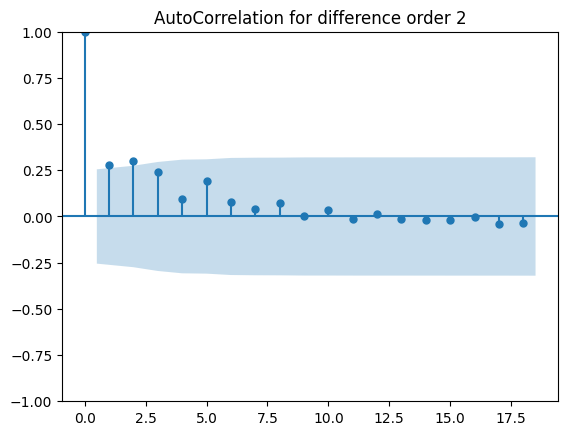

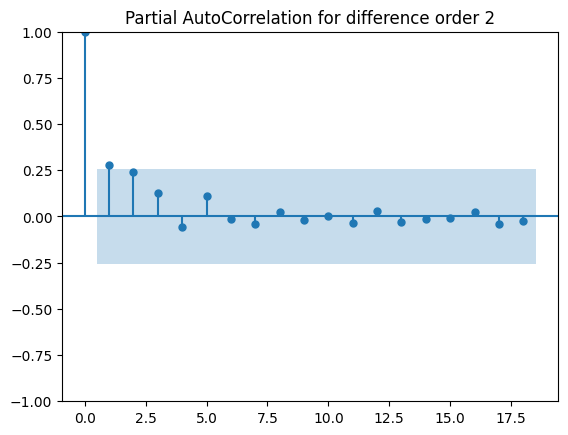

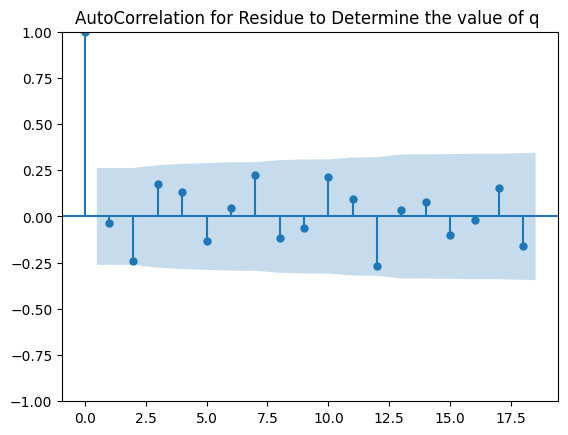

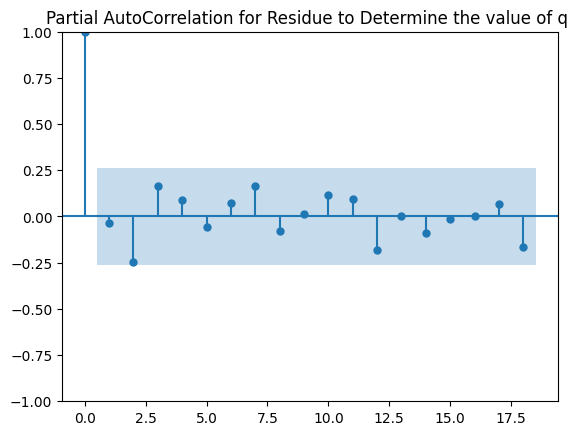

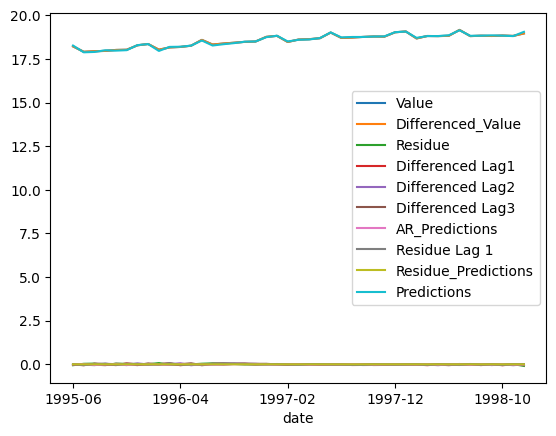

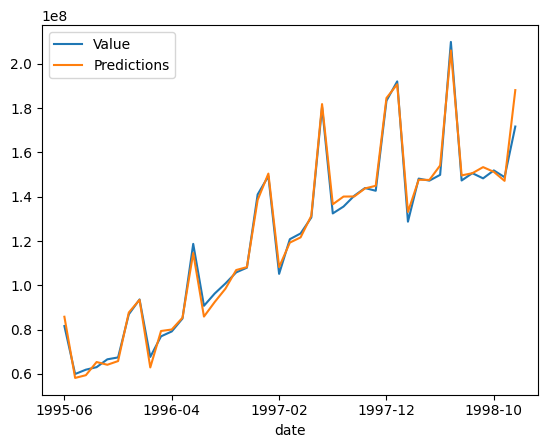

In [58]:

def ARIMA(df,p,q,d):

    #DIFFERENCING : Making data stationary
    d-=1
    df_diff=df.copy()
    df_diff['Value']=np.log(df.Value)
    order=[1,12]
    temp=I(df_diff['Value'],order)
    df_diff['Differenced_Value']=temp[0]
            
    df_diff=df_diff.dropna()
    print(df_diff)
    
    
    #THE AR MODEL
    p=3#This Value Was Set after looking at the graph of acf and pacf of difference series
    temp=(AR(p,df_diff))
    AR_RMSE=temp[0]

    print(type(temp))
    df_diff['Residue']=temp[1]['Residuals']
    theta1=temp[2]
    intercpt1=temp[3]
    df_diff=df_diff.dropna()
    plot_acf(df_diff['Residue'],title="AutoCorrelation for Residue to Determine the value of q ")
    plot_pacf(df_diff['Residue'],title="Partial AutoCorrelation for Residue to Determine the value of q ")

    print(df_diff)

    #THE MA MODEL
    q=1 #This Value Was Set after looking at the graph of acf and pacf of Residue series
    temp=MA(q,df_diff)
    theta2=temp[0]
    intercpt2=temp[1]
    
    #PREDICTING
    predict_data=df_diff.copy()
    i=1
    while(i<=p):
        
        predict_data[f'Differenced Lag{i}']=predict_data['Differenced_Value'].shift(i)
        i+=1
    
    i=1
    predict_data['AR_Predictions']= predict_data.iloc[:,3:].dot(theta1)+intercpt1
    
    while(i<=q):
        
        predict_data[f'Residue Lag {i}']=predict_data['Residue'].shift(i)
        i+=1

    
    
    predict_data['Residue_Predictions']= (predict_data.iloc[:,4+p:].dot(theta2)+intercpt2)
    predict_data['Predictions']=predict_data["AR_Predictions"]+predict_data['Residue_Predictions']
    df_diff['Differenced_Predictions']=predict_data['Predictions']
    print(df_diff.dropna())
    
    #Getting Back Data
    predict_data=GetBackData(predict_data,order).dropna()   
    predict_data.plot()
    predict_data['Predictions']=np.exp(predict_data['Predictions'])
    
     

    #The Graph
    ForGraph=df.copy().iloc[(df.shape[0])-predict_data.shape[0]::]
    ForGraph['Predictions']=predict_data['Predictions']
    ForGraph.iloc[-100::].plot()
    
    
ARIMA(df,1,0,1)
    

